# Introduction

The goal of this project is to train an AI capable of picking up a passenger at a random location and driving him to another random location, for this we compared several algorithms Q-Learning, SARSA and Deep Q Learning.

  In order to define which algorithm is the best to solve the Taxi-v3 game, we had to test our solutions with diffrents configurations. Then we compared each algorithm with the others.
<br><br>
The first step allowed us to find the best parameters for each algorithms.
<br><br>
With the second one, we choose parameters and test each algorithm with these parameters to find out the best one.
We also compare the best run of the algorithms no matter the parameters setted.
<br><br>
Our main metric is the average reward for each step of an episode. As incorrect moves are severly punished by the game, a well trained algorithm should be positive in term of reward.

# Parameters and Initialisations

Add library (if needed)

In [ ]:
!pip install keras-rl2
!pip install tensorflow
!pip install wandb
!wandb login

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52 kB 617 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.1 MB/s 
     |████████████████████████████████| 181 kB 42.1 MB/s 
     |████████████████████████████████| 145 kB 51.3 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=ecd2d1f8ae644dcec755d3a0414f8abfa65431097d462ab5707ad3e4b5ae505c
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find you

Import needed to run the project

In [ ]:
import gym
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Embedding, Reshape
from tensorflow.keras.optimizers import Adam
from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory
from time import sleep
import random
from datetime import datetime
import time
from IPython.display import clear_output
import wandb
from wandb.keras import WandbCallback

Gym Taxi-v3 init

In [ ]:
env = gym.make("Taxi-v3").env
env.render()

print("Number of actions: %d" % env.action_space.n)
print("Number of states: %d" % env.observation_space.n)

action_size = env.action_space.n
state_size = env.observation_space.n

np.random.seed(123)
env.seed(123)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Number of actions: 6
Number of states: 500


[123]

Settings:



* epsilon: epsilon is our way of balancing actions between exploration and exploitation, the idea here is that as the number of epsilons decreases, our agent will take more exploitation actions and vice versa.
An episode starts when you start the environment and ends when your agent arrives in an action terminal such as lost the game
----------------------------------------------------------
*   max_espilon: Defines the maximum that the value epsilon can reach
----------------------------------------------------------
*   episode: Defines the number of episode the program will play
----------------------------------------------------------
*   gamma: gamma is a discount factor. It is used to balance the immediate and future reward.
----------------------------------------------------------
*   min_espilon: Defines the minimum that the value epsilon can reach
----------------------------------------------------------
*   alpha: alpha is the learning rate. If the reward or transition function is stochastic (random), then alpha should change over time, approaching zero at infinity.
----------------------------------------------------------
*   max_steps: Defines the maximum step that the program will play for each episode
----------------------------------------------------------




In [ ]:
### Average from Q-learning and Sarsa
epsilon = 1
max_epsilon = 1
episodes = 25000
gamma = 0.97
min_epsilon = 0.001
epsilon_decay = 0.01
alpha = 0.44
max_steps = 99

# Brute force Algorithm

In [ ]:
### BRUTEFORCE

# Setting the number of iterations, penalties and reward to zero,
epochs = 0
penalties = 0
reward = 0

frames = []

done = False

# WANDB data for graphs
wandb.init(project="Taxi Driver", entity="nostradamovies")


for i in range(0,1000):
  total_reward = 0
  done = False
  env.reset()
  while not done:
      action = env.action_space.sample()
      state, reward, done, info = env.step(action)
      total_reward += reward
      


      if reward == -10:
          penalties += 1

      # Put each rendered frame into the dictionary for animation
      frames.append({
          'frame': env.render(mode='ansi'),
          'state': state,
          'action': action,
          'reward': reward
      })

      epochs += 1

  wandb.log({"episode_reward": total_reward})

# Printing all the possible actions, states, rewards.
def renderFrames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        print("Timesteps taken: {}".format(epochs))
        print("Penalties incurred: {}".format(penalties))
        sleep(.1)
        
#renderFrames(frames)

Just to show how naive a bruteforce run can be, we track two run of 1000 episode and display the average reward per episode.

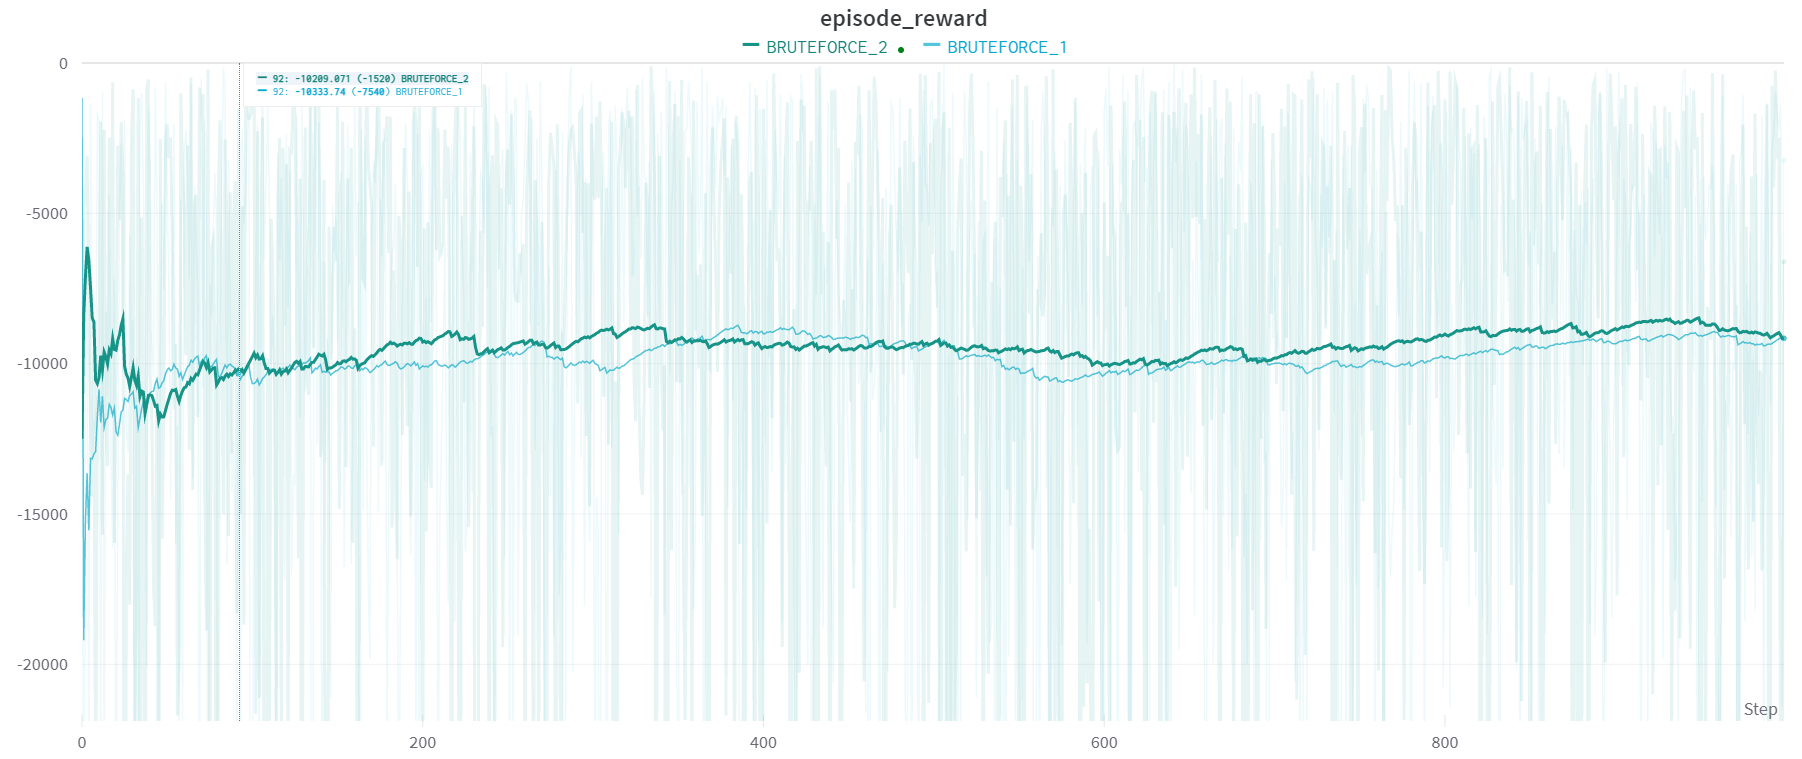

As you can see, it's absolutelly imprevisible and switch from an almost nice run to a desaster which lead to a really low average reward per episode.

# Q-learning and Sarsa

Q-learning is both relatively simple and at the same time allows us to understand learning mechanisms common to many other models.

To illustrate in an introductory way, a Q-learning algorithm works to solve a basic problem. For example, in the maze game, the objective of the game is to teach the robot to get out of the maze as quickly as possible while it is randomly placed on one of the white squares. For this, there are three central steps in the learning process:

* Knowing: defining an action-value function Q
* Reinforce knowledge: update the Q function

Q-learning is a reinforcement learning algorithm that seeks to find the best action to take given the current state. It is considered out-of-policy because the Q-learning function learns actions that are outside of the current policy, such as taking random actions, and thus a policy is not required. Specifically, Q-learning seeks to learn a policy that maximizes the total reward.

In [ ]:
### QLEARNING TRAIN

def train_qlearning(epsilon= 1
        , max_epsilon = 1
        , episodes = 25000
        , gamma = 0.99
        , min_epsilon= 0.001
        , epsilon_decay = 0.01
        , alpha = 0.01
        , max_steps = 99
      ):
  
    # WANDB data for graphs
    wandb.init(project="Taxi Driver", entity="nostradamovies")

    start_date = datetime.now()
    start_time = time.time()
    total_reward = []
    steps_per_episode = []

    print("/***************************************************/")
    print("epsilon",  epsilon)
    print("max_epsilon",  max_epsilon)
    print("gamma",  gamma)
    print("min_epsilon",  min_epsilon)
    print("epsilon_decay",  epsilon_decay)
    print("alpha",  alpha)
    print("/***************************************************/")

    q_table = np.zeros((state_size, action_size))

    print("{} - Starting Training\n".format(start_date))
    for episode in range(episodes):
        start_episode = time.time()
        total_reward.append(0)
        steps_per_episode.append(0)

        reward = 0

        state = env.reset()
        step = 0
        done = False

        for step in range(max_steps):
            exp_exp_tradeoff = random.uniform(0,1)

            ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
            if exp_exp_tradeoff > epsilon:
                action = np.argmax(q_table[state,:])

            # Else doing a random choice --> exploration
            else:
                action = env.action_space.sample()

            # Take the action (a) and observe the outcome state(s') and reward (r)
            new_state, reward, done, info = env.step(action)
            total_reward[episode] += reward
            steps_per_episode[episode] += 1

            # Update Q(s,a) = Q(s,a) + alpha [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
            q_table[state, action] = q_table[state, action] + alpha * (reward + gamma *
                                        np.max(q_table[new_state, :]) - q_table[state, action])

            # Our new state is state
            state = new_state

            # If done : finish episode
            if done == True:
                break

        wandb.log({"episode_reward": total_reward[episode]})

    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-epsilon_decay*episode)

    end_date = datetime.now()
    execution_time = (time.time() - start_time)

    print("/***************************************************/")
    print("{} - Training Ended".format(end_date))
    print("Mean Reward: {}".format(np.mean(total_reward)))
    print("Mean Step: {}".format(np.mean(steps_per_episode)))
    print("Time to train: \n    - {}s\n    - {}min\n    - {}h".format(
        np.round(execution_time, 2), np.round(execution_time / 60, 2),
        np.round(execution_time / 3600, 2)))
    
    np.save("q_table_qlearning", q_table)

    print ("Train done, q_table_qlearning saved")

Updates occur after each step or action and end when an episode is completed. In this case, "completed" means that the agent has reached an endpoint. For example, an end state might land on a payment page or achieve a desired goal. With enough exploration (steps and episodes), the agent will be able to converge and learn the optimal values of q or q-star (Q∗).

The 3 basic steps are as follows:

* The agent starts in a state (s1) takes an action (a1) and receives a reward (r1).
* The agent chooses the action by referring to the Q-table with the highest value (max) OR at random (epsilon, ε).

Updating the q-values
* The basic update rule for Q-learning is as follows:


SARSA is a learning algorithm. Its name is an acronym for State-Action-Reward-State-Action1 . It is an on-policy algorithm: it uses the policy being learned to update the learned internal values.

In [ ]:
### Function play Qlearning

def play_qlearning(slow=False):
    env = gym.make("Taxi-v3")

    q_table = np.load("q_table_qlearning.npy")
    done = False
    result = 0
    state = env.reset()

    env.render(mode='ansi')
    steps = 0

    while not done:
        action = np.argmax(q_table[state])
        next_state, reward, done, _ = env.step(action)

        result += reward
        state = next_state

        print(env.render(mode='ansi'))
            
        steps += 1

        if steps >= 99:
            break

        if slow:
            input("Press anything to continue...")
            print("\r", end="\r")


    print("****************************************************")
    print("[{} MOVES] - Total reward: {}".format(steps, result))

    env.close()

    return steps, result

In [ ]:
### SARSA TRAIN

def train_sarsa(episodes = 25000
      , gamma = 0.95
      , epsilon = 1
      , max_epsilon = 1
      , min_epsilon = 0.001
      , epsilon_decay = 0.01
      , alpha = 0.85
    ):
  
    # WANDB data for graphs
    wandb.init(project="Taxi Driver", entity="nostradamovies")

    start_date = datetime.now()
    start_time = time.time()
    total_reward = []
    steps_per_episode = []
    
    print("/***************************************************/")
    print("epsilon",  epsilon)
    print("max_epsilon",  max_epsilon)
    print("gamma",  gamma)
    print("min_epsilon",  min_epsilon)
    print("epsilon_decay",  epsilon_decay)
    print("alpha",  alpha)
    print("/***************************************************/")

    Q = np.zeros((env.observation_space.n, env.action_space.n))

    reward = 0

    print("{} - Starting Training\n".format(start_date))
    for episode in range(episodes):
      start_episode = time.time()
      done = False
      total_reward.append(0)
      steps_per_episode.append(0)
      state1 = env.reset()

      epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-epsilon_decay * episode)

      if np.random.uniform(0, 1) < epsilon:
          action1 = env.action_space.sample()
      else:
          action1 = np.argmax(Q[state1, :])

      while not done:
          state2, reward, done, _ = env.step(action1)
          total_reward[episode] += reward
          steps_per_episode[episode] += 1
          if np.random.uniform(0, 1) < epsilon:
              action2 = env.action_space.sample()
          else:
              action2 = np.argmax(Q[state2, :])

          predict = Q[state1, action1]
          target = reward + gamma * Q[state2, action2]

          # Update Q(s,a) = Q(s,a) + alpha * ((r + y * Q(s',a') - Q(s,a))
          Q[state1,action1] = Q[state1, action1] + alpha * (target - predict)
            
          state1 = state2
          action1 = action2

          reward += 1

      wandb.log({"episode_reward": total_reward[episode]})

    end_date = datetime.now()
    execution_time = (time.time() - start_time)

    print("{} - Training Ended".format(end_date))
    print("Mean Reward: {}".format(np.mean(total_reward)))
    print("Mean Step: {}".format(np.mean(steps_per_episode)))
    print("Time to train: \n    - {}s\n    - {}min\n    - {}h".format(
        np.round(execution_time, 2), np.round(execution_time / 60, 2),
        np.round(execution_time / 3600, 2)))

    np.save("q_table_sarsa", Q)

The name SARSA stands for State-Action-Reward-State-Action which is the sequence of mathematical elements considered by the algorithm:

* the algorithm considers the current state s (for example, the position of a robot in an environment and the position of its arms)
----------------------------------------------------------
* then it chooses an action to execute according to what it has already learned, but also an exploration bias to arouse its curiosity and try non recommended actions. He performs this action
----------------------------------------------------------
* he then receives a reward r. For example, if the robot is still alive, we can decide to give it a reward of 1€, while if it falls, it loses 100€ (i.e. a negative reward of -100€)
----------------------------------------------------------
* it perceives the new state s' (for example, its new position)
----------------------------------------------------------
* he chooses the new action a' to execute

The update of its internal values takes into account the value Q(s', a') and Q(s, a) and the reward r. We say that SARSA is an on-policy algorithm because the update takes into account in particular Q(s', a'), where a' has been chosen by the learning policy.

The SARSA algorithm is a slight variation of the popular Q-Learning algorithm. For a learning agent in any reinforcement learning algorithm, its policy can be of two types: - On strategy: in this case, the learning agent learns the value function based on the current action derived from the strategy

On Policy: In this case, the learning agent learns the value function based on the current action derived from the currently used policy.
Off Policy: In this case, the learning agent learns the value function based on the action derived from another policy.
The Q-Learning technique is an Off Policy technique and uses the greedy approach to learn the Q-value. The SARSA technique, on the other hand, is an On Policy and uses the action performed by the current policy to learn the Q-value.

This difference can be seen in the difference in the update instructions for each technique:

* Q-Learning: Q(s,a) = Q(s,a) + alpha [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
* Sarsa: Q(s,a) = Q(s,a) + alpha * ((r + y * Q(s',a') - Q(s,a))

Here, the update equation for SARSA depends on the current state, the current action, the reward obtained, the next state and the next action. This observation led to naming the learning technique as SARSA stands for State Action Reward State Action which symbolizes the tuple (s, a, r, s ', a').

In Q learning, we take action using an epsilon-greedy policy and, while updating the Q value, we simply pick up the maximum action. In SARSA, we take the action using the epsilon-greedy policy and also, while updating the Q value, we pick up the action using the epsilon-greedy policy.

In [ ]:
### Function play Sarsa

def play_sarsa(slow=False):
    env = gym.make("Taxi-v3")

    q_table = np.load("q_table_sarsa.npy")
    done = False
    result = 0
    state = env.reset()
        
    steps = 1

    while not done:
        print(env.render(mode='ansi'))

        action = np.argmax(q_table[state])
        next_state, reward, done, _ = env.step(action)

        result += reward
        state = next_state

        steps += 1

        if steps >= 100:
            break

        if slow:
            input("Press anything to continue...")
            print("\r", end="\r")
            
    print("****************************************************")
    print("[{} MOVES] - Total reward: {}".format(steps, result))

    return steps, result

In [ ]:
def play_n_times(n, algorithme):
  step_average = 0
  result_average = 0
  total_failed = 0

  for l in range(n):
    steps, result = algorithme
    step_average += steps
    result_average += result
    if steps >= 100:
      total_failed += 1

      print("****************************************************")
      print("Summary result:")
      print(f"{n} loop")
      print(f"Average Steps Per Loop: {np.round(step_average / n, 2)}")
      print(f"Average Reward Per Loop: {np.round(result_average / n, 2)}")

In [ ]:
### Launch training Qlearning with general / custom paramaters

"""
epsilon = 1
max_epsilon = 1
episodes = 25000
gamma = 0.97
min_epsilon = 0.001
epsilon_decay = 0.01
alpha = 0.44
max_steps = 99
"""

train_qlearning(episodes = episodes
                , gamma = gamma
                , epsilon = epsilon
                , max_epsilon = max_epsilon
                , min_epsilon = min_epsilon
                , epsilon_decay = epsilon_decay
                , alpha = alpha
                , max_steps = max_steps)

/***************************************************/
epsilon 1
max_epsilon 1
gamma 0.97
min_epsilon 0.001
epsilon_decay 0.01
alpha 0.44
/***************************************************/
2022-06-19 12:41:43.733138 - Starting Training

/***************************************************/
2022-06-19 12:43:54.212894 - Training Ended
Mean Reward: -387.4276
Mean Step: 98.59228
Time to train: 
    - 130.48s
    - 2.17min
    - 0.04h
Train done, q_table_qlearning saved


In [ ]:
### Play n times Qlearning

n = 5
slow = False
algorithme = play_qlearning(slow)
play_n_times(n, algorithme)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)

+---------+
|R: | :_:G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

+---------+
|R: | : :G|
| : | :_: |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : 

In [ ]:
### Launch training Qlearning with default paramaters
train_qlearning()

/***************************************************/
epsilon 1
max_epsilon 1
gamma 0.99
min_epsilon 0.001
epsilon_decay 0.01
alpha 0.01
/***************************************************/
2022-06-19 12:54:17.627860 - Starting Training

/***************************************************/
2022-06-19 12:56:30.143165 - Training Ended
Mean Reward: -387.463
Mean Step: 98.55424
Time to train: 
    - 132.52s
    - 2.21min
    - 0.04h
Train done, q_table_qlearning saved


In [ ]:
### Play n times Qlearning
n = 5
slow = False
algorithme = play_qlearning(slow)
play_n_times(n, algorithme)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)

+---------+
|R: | :_:G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

+---------+
|R: | : :G|
| : | :_: |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : |_: : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : 

In [ ]:
### Launch training Sarsa with general / custom parameters

"""
epsilon = 1
max_epsilon = 1
episodes = 25000
gamma = 0.97
min_epsilon = 0.001
epsilon_decay = 0.01
alpha = 0.44
max_steps = 99
"""

train_sarsa(episodes = episodes
            , gamma = gamma
            , epsilon = epsilon
            , max_epsilon = max_epsilon
            , min_epsilon = min_epsilon
            , epsilon_decay = epsilon_decay
            , alpha = alpha
            )

/***************************************************/
epsilon 1
max_epsilon 1
gamma 0.97
min_epsilon 0.001
epsilon_decay 0.01
alpha 0.44
/***************************************************/
2022-06-19 12:57:23.264344 - Starting Training

2022-06-19 12:57:50.279739 - Training Ended
Mean Reward: -5.459
Mean Step: 20.13776
Time to train: 
    - 27.02s
    - 0.45min
    - 0.01h


In [ ]:
### Play n times Sarsa
n = 5
slow = False
algorithme = play_sarsa(slow)
play_n_times(n, algorithme)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| :

In [ ]:
### Launch training Sarsa with default parameters

train_sarsa()

/***************************************************/
epsilon 1
max_epsilon 1
gamma 0.95
min_epsilon 0.001
epsilon_decay 0.01
alpha 0.85
/***************************************************/
2022-06-19 12:58:18.743056 - Starting Training

2022-06-19 12:59:34.236807 - Training Ended
Mean Reward: -78.64308
Mean Step: 92.08812
Time to train: 
    - 75.49s
    - 1.26min
    - 0.02h


Comparing both training:

Genral params =
* epsilon = 1
* max_epsilon = 1
* episodes = 25000
* gamma = 0.97
* min_epsilon = 0.001
* epsilon_decay = 0.01
* alpha = 0.44
* max_steps = 99


-------------------------------------------------------------
Q-learning:

* epsilon = 1
* max_epsilon = 1
* episodes = 25000
* gamma = 0.97
* min_epsilon = 0.001
* epsilon_decay = 0.01
* alpha = 0.01
* max_steps = 99

-------------------------------------------------------------

General params: 
* Mean Reward: 0.52804
* Mean Step: 15.7004
* 10.04s
* 0.17min

[13 MOVES] - Total reward: 8

Defaut params:
* Mean Reward: -387.32252
* Mean Step: 98.60888
* 76.82s
* 1.28min

[16 MOVES] - Total reward: 5

-------------------------------------------------------------
Sarsa:

* epsilon = 1
* max_epsilon = 1
* episodes = 25000
* gamma = 0.95
* min_epsilon = 0.001
* epsilon_decay = 0.01
* alpha = 0.85
* max_steps = 99

-------------------------------------------------------------

General params: 
* Mean Reward: -1.77116
* Mean Step: 17.0666
* 9.02s
* 0.15min

[22 MOVES] - Total reward: 0

Defaut params:
* Mean Reward: -84.05384
* Mean Step: 97.58816
* Time to train: 
* 47.84s
* 0.8min

[13 MOVES] - Total reward: 9


In [ ]:
### Play n times Sarsa
n = 5
slow = False
algorithme = play_sarsa(slow)
play_n_times(n, algorithme)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B:_|
+---------+
  (East)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | :_|
|Y| : |B: |
+---------+
  (North)

+---------+
|R: | : :G|
| : | : : |
| : : : :_|
| | : | : |
|Y| : |B: |
+---------+
  (North)

+---------+
|R: | : :G|
| : | : :_|
| : : : : |
| | : | : |


They mostly look the same except that in SARSA we take actual action and in Q Learning we take the action with highest reward.

Actually in both you "take" the actual single generated action at+1 next. In Q learning, you update the estimate from the maximum estimate of possible next actions, regardless of which action you took. Whilst in SARSA, you update estimates based on and take the same action.

This is probably what you meant by "take" in the question, but in the literature, taking an action means that it becomes the value of e.g. at, and influences rt+1, st+1.

Are there any theoretical or practical settings in which one should the prefer one over the other?

Q-learning has the following advantages and disadvantages compared to SARSA:

* Q-learning directly learns the optimal policy, whilst SARSA learns a near-optimal policy whilst exploring. If you want to learn an optimal policy using SARSA, then you will need to decide on a strategy to decay ϵ in ϵ-greedy action choice, which may become a fiddly hyperparameter to tune.

* Q-learning (and off-policy learning in general) has higher per-sample variance than SARSA, and may suffer from problems converging as a result. This turns up as a problem when training neural networks via Q-learning.

* SARSA will approach convergence allowing for possible penalties from exploratory moves, whilst Q-learning will ignore them. That makes SARSA more conservative - if there is risk of a large negative reward close to the optimal path, Q-learning will tend to trigger that reward whilst exploring, whilst SARSA will tend to avoid a dangerous optimal path and only slowly learn to use it when the exploration parameters are reduced. The classic toy problem that demonstrates this effect is called cliff walking.

In practice the last point can make a big difference if mistakes are costly - e.g. you are training a robot not in simulation, but in the real world. You may prefer a more conservative learning algorithm that avoids high risk, if there was real time and money at stake if the robot was damaged.

If our goal is to train an optimal agent in simulation, or in a low-cost and fast-iterating environment, then Q-learning is a good choice, due to the first point (learning optimal policy directly). If your agent learns online, and you care about rewards gained whilst learning, then SARSA may be a better choice.

## Analysis and Comparison

Even if Q-learning and SARSA are quite similar in their operation, results may vary a lot depending on the configuration.

Therefore, we need to find out which one is the best by comparing them, firstly alone with différents parameters then with each other.

### Q-learning

The graph below shows the evolution of a Q-learning algorithms over 25 000 episodes.

The average reward of an episode stay really low during all the training, no matter which parameters are used.

However, Q-learning manage to do some good run when testing but it's not really reliable.

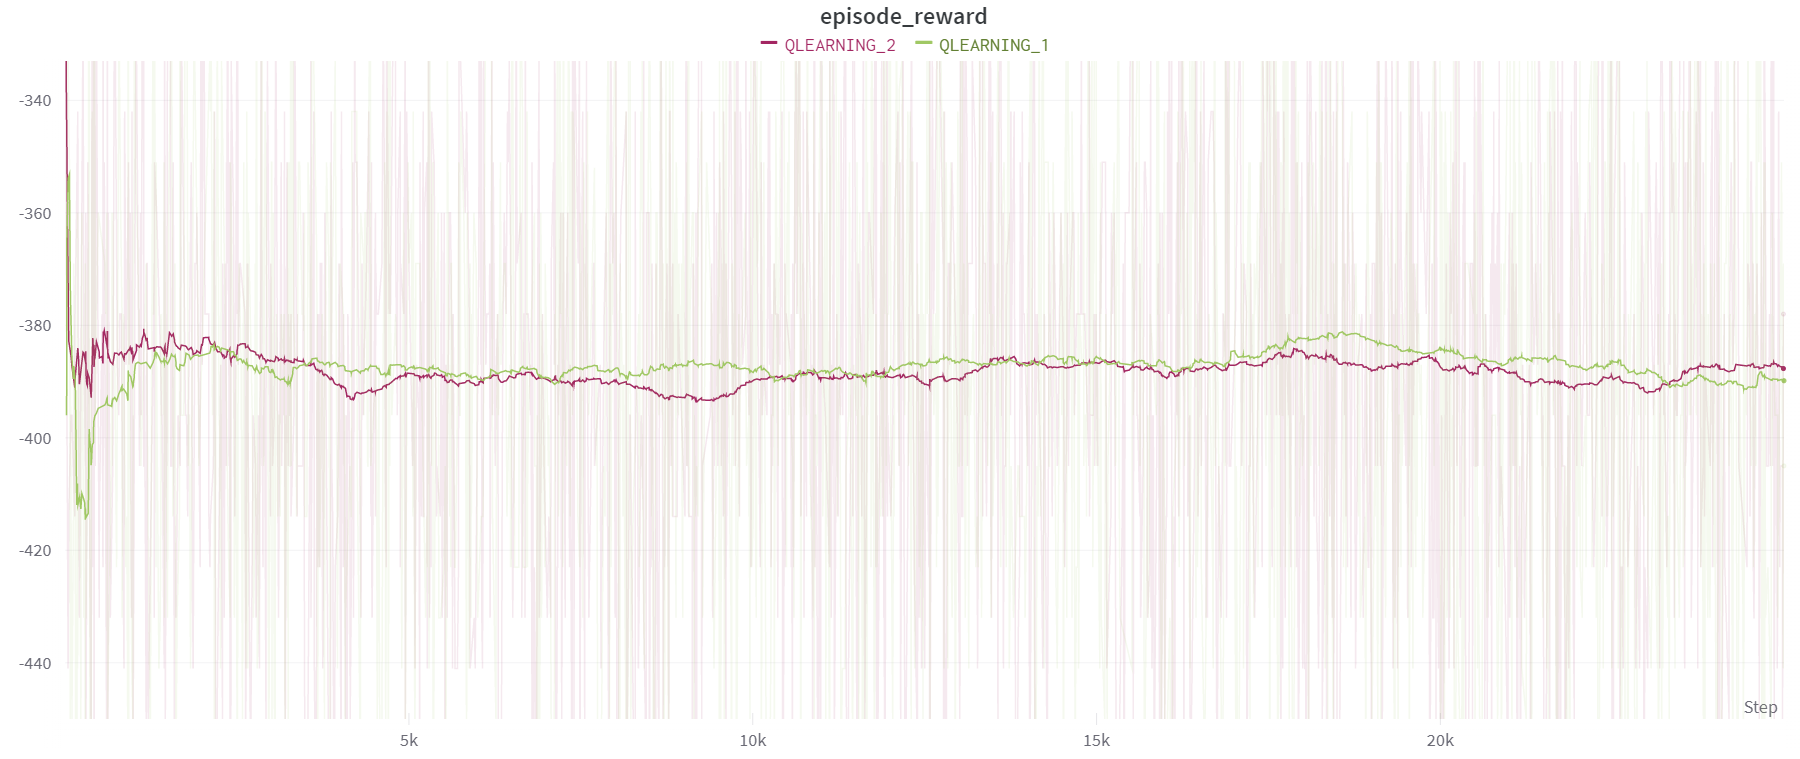

### Sarsa

The graph below shows the evolution of a SARSA algorithms over 25 000 episodes.

The first one (grey, optimized parameter) quickly reaches a good state with an almost alkways positive reward by episode.

The second one (blue, generics parameters used in common with all the algorithms) shows a strange behavior due to the parameters. Even if it mainly improve and increase it reward, there is sometimes issues that made step back the progress preventing the run to reach an acceptable performance.

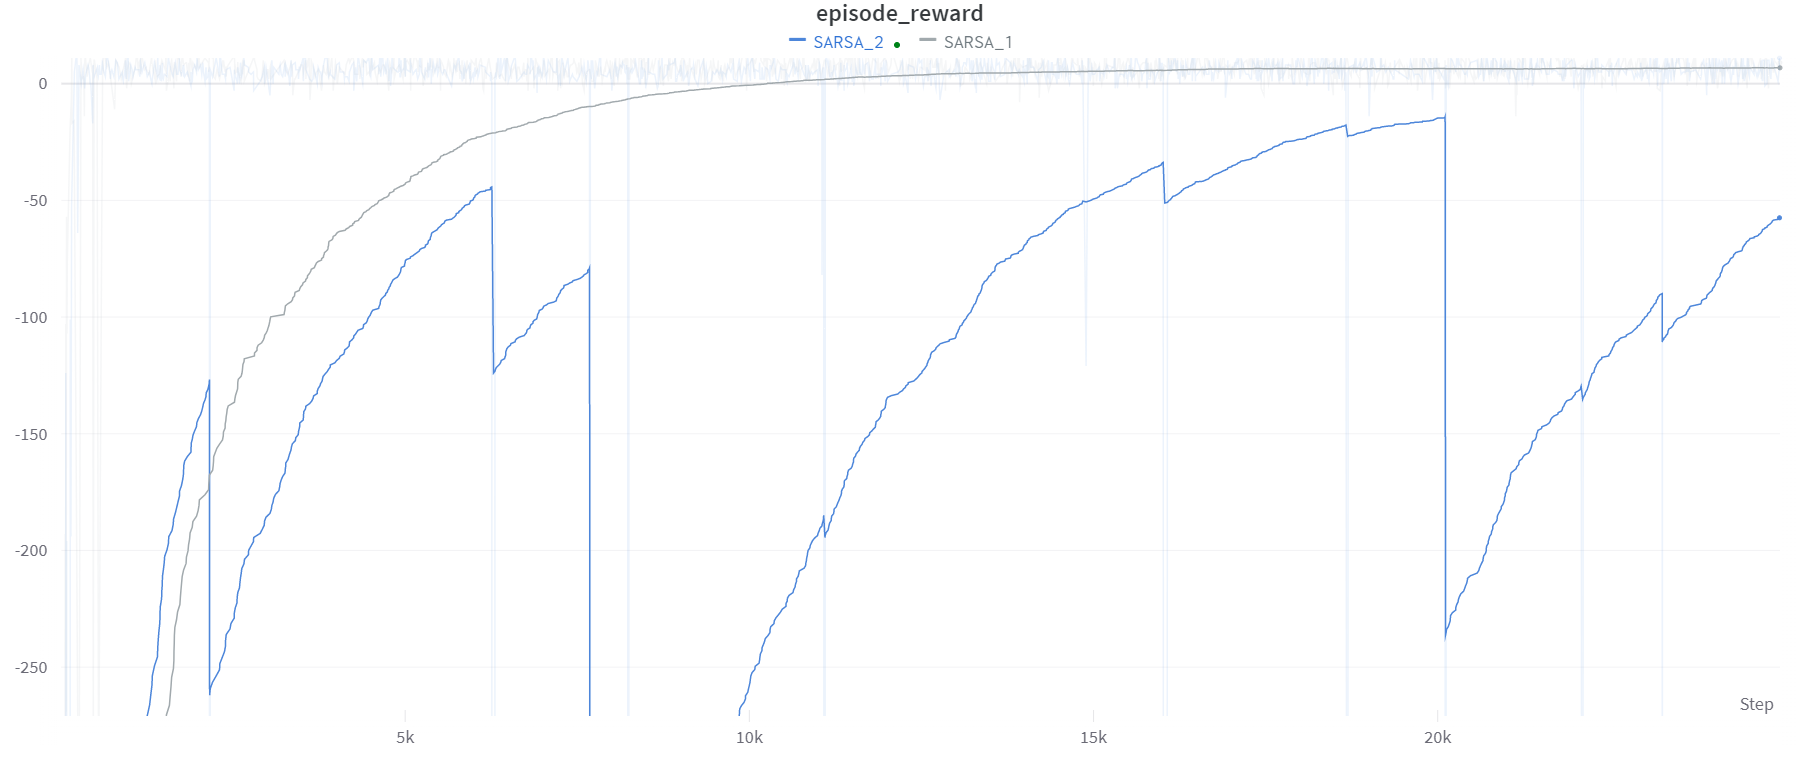

### Q-learning vs Sarsa

Even though Q-learning and SARSA both have good results with the game and perform way better then the bruteforce, SARSA remains superior than Q-learning.



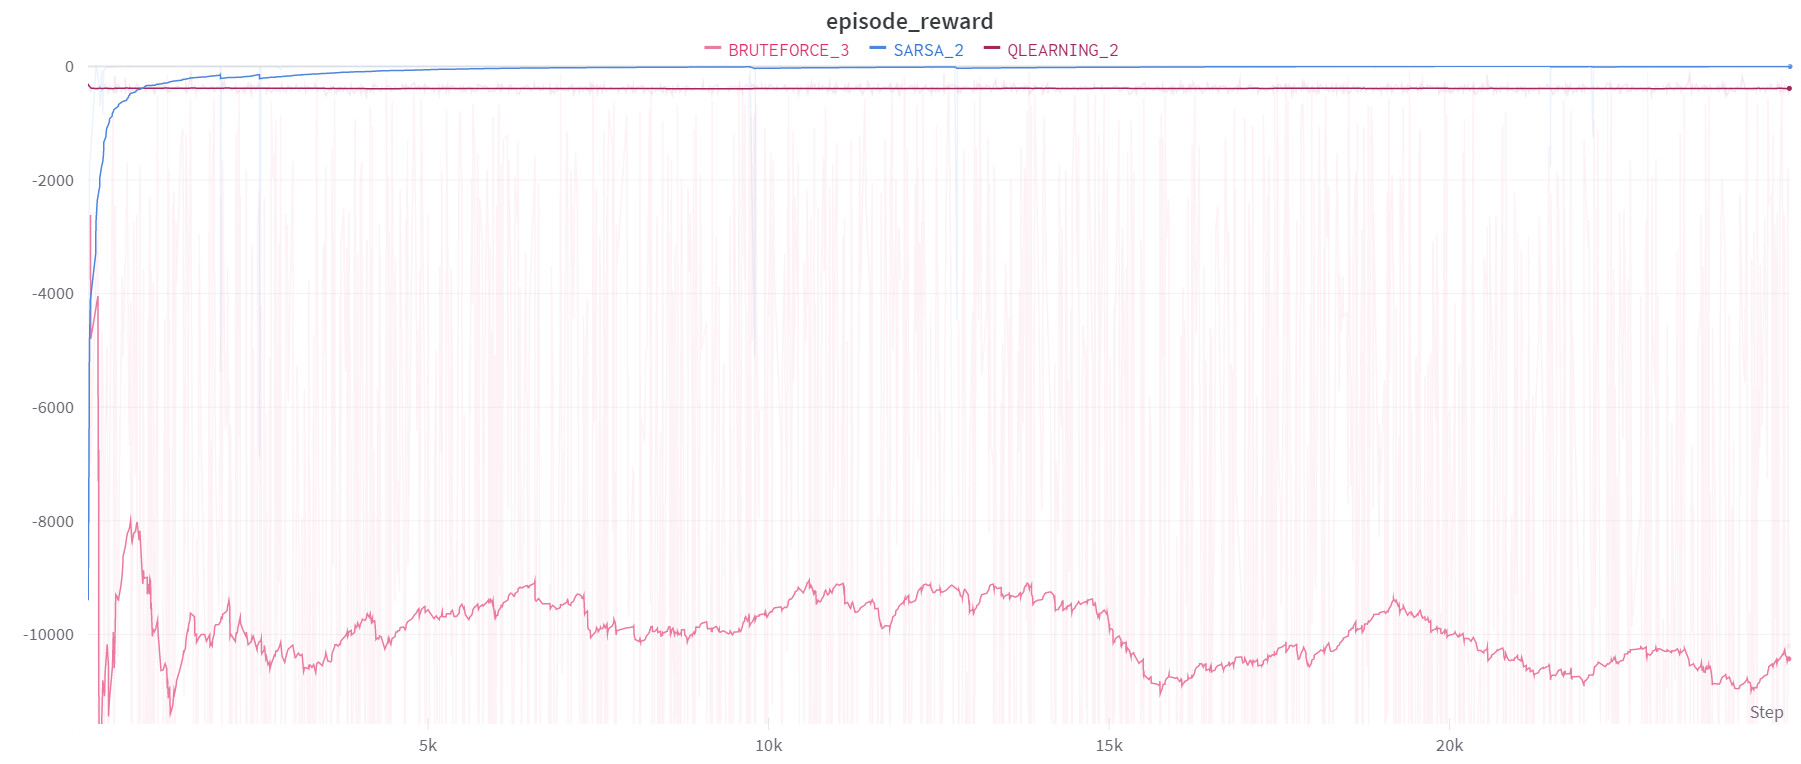

It's even mort blatant when we compare the two algortihms with their own optimized parameters.

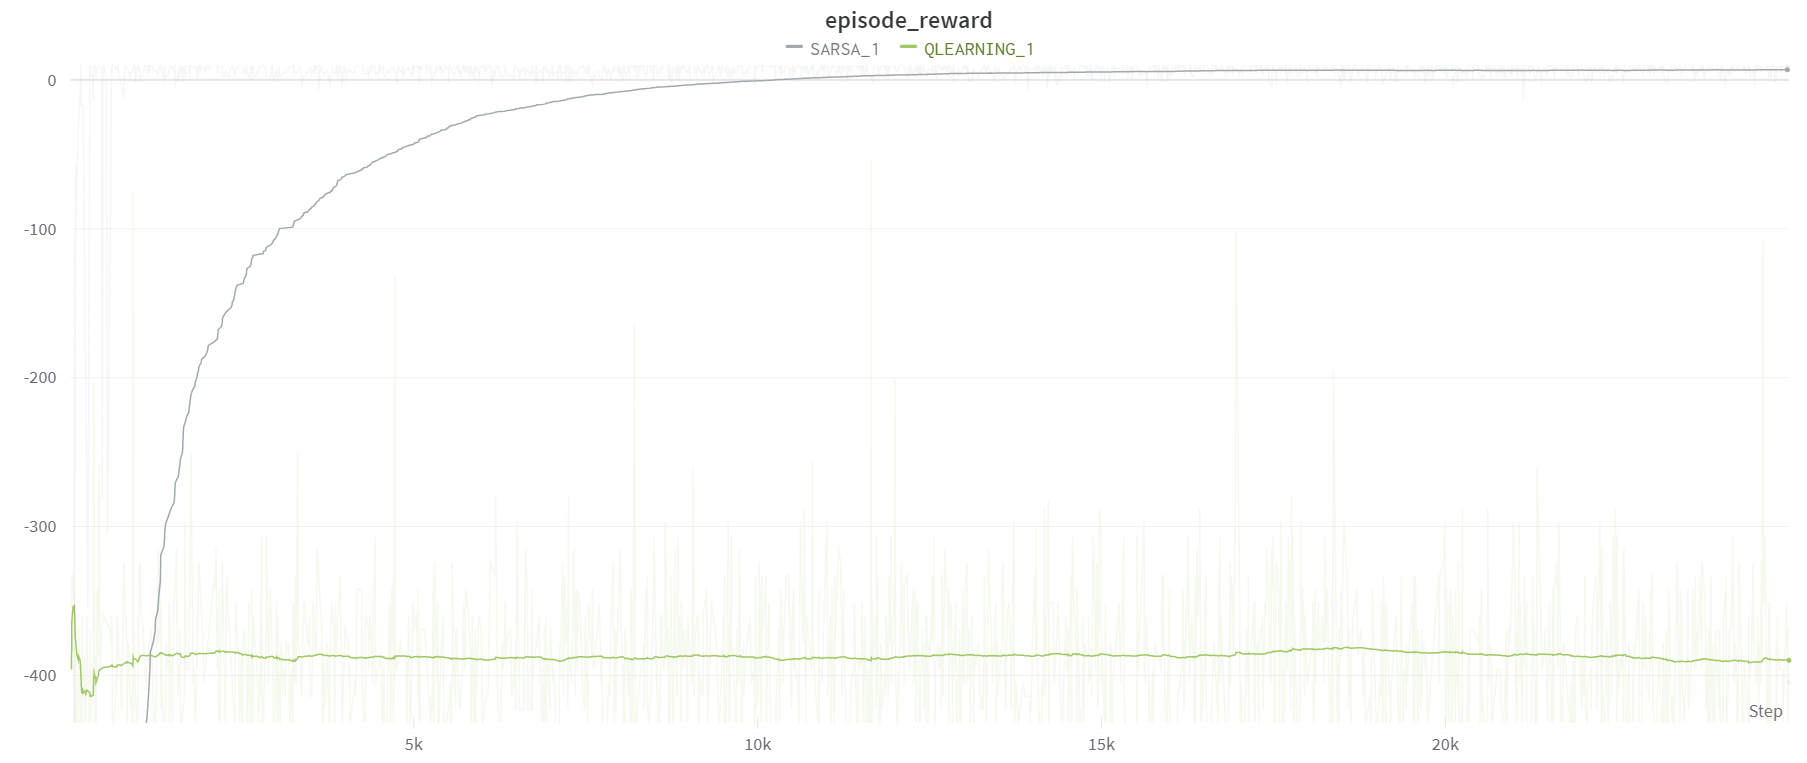

# Deep Q-Network (DQN)

We run the différents trainings with 1 000 000 steps. It may seems quite high but as some configurations evolve slowly, we wanted to be sure to let each variations reaches it best state. 

Hyperparameters

In [ ]:
epsilon = 0.1
target_model_update = 1e-2
learning_rate = 1e-3

Reset environement

In [ ]:
env.reset()
env.step(env.action_space.sample())[0]

414

## Model

Sequential model with multiple dense layer

In [ ]:
model = Sequential()
model.add(Embedding(500, 10, input_length=1))
model.add(Reshape((10,)))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(action_size, activation='linear'))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1, 10)             5000      
                                                                 
 reshape_1 (Reshape)         (None, 10)                0         
                                                                 
 dense_4 (Dense)             (None, 50)                550       
                                                                 
 dense_5 (Dense)             (None, 50)                2550      
                                                                 
 dense_6 (Dense)             (None, 50)                2550      
                                                                 
 dense_7 (Dense)             (None, 6)                 306       
                                                                 
Total params: 10,956
Trainable params: 10,956
Non-trai

## Training

Training of the model with espilon greedy policy

  As you can see, in the beginning, rewards were quite low due to the untrained model. But, step by step, the quality increase until the reward become positive.

In [ ]:
memory = SequentialMemory(limit=50000, window_length=1)
policy = EpsGreedyQPolicy(eps=epsilon)
dqn = DQNAgent(model=model, nb_actions=action_size, memory=memory, nb_steps_warmup=500, target_model_update=target_model_update, policy=policy)
dqn.compile(Adam(learning_rate=learning_rate), metrics=['mae'])
dqn.fit(env, nb_steps=1000000, visualize=False, verbose=1, nb_max_episode_steps=99, log_interval=100000)

Training for 1000000 steps ...
Interval 1 (0 steps performed)
    48/100000 [..............................] - ETA: 1:47 - reward: -8.8750    

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  7492/100000 [=>............................] - ETA: 13:24 - reward: -1.7328done, took 65.283 seconds


## Testing

Once trained, the model is used to test the game

In [ ]:
dqn.test(env, nb_episodes=5, visualize=True, nb_max_episode_steps=99)

Testing for 5 episodes ...
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : :

## Analysis

### Impact of the Epsylon parameter


The parameter Espilon is used for a greedy policy. It allows the model to sometimes choose randomly the next action to use. The value of Epsilon defines the probability for the model to act randomly. The higher espilon is, the more randomly chosen the next action is.

As it seems obvious that an espilon too high will lead to an untrainable and unpredictable model, we choose to stop with an epsilon of 0.5. (50% random)
<br>So, we tried 3 runs with 3 différents epsilon : 0.1, 0.3 and 0.5.

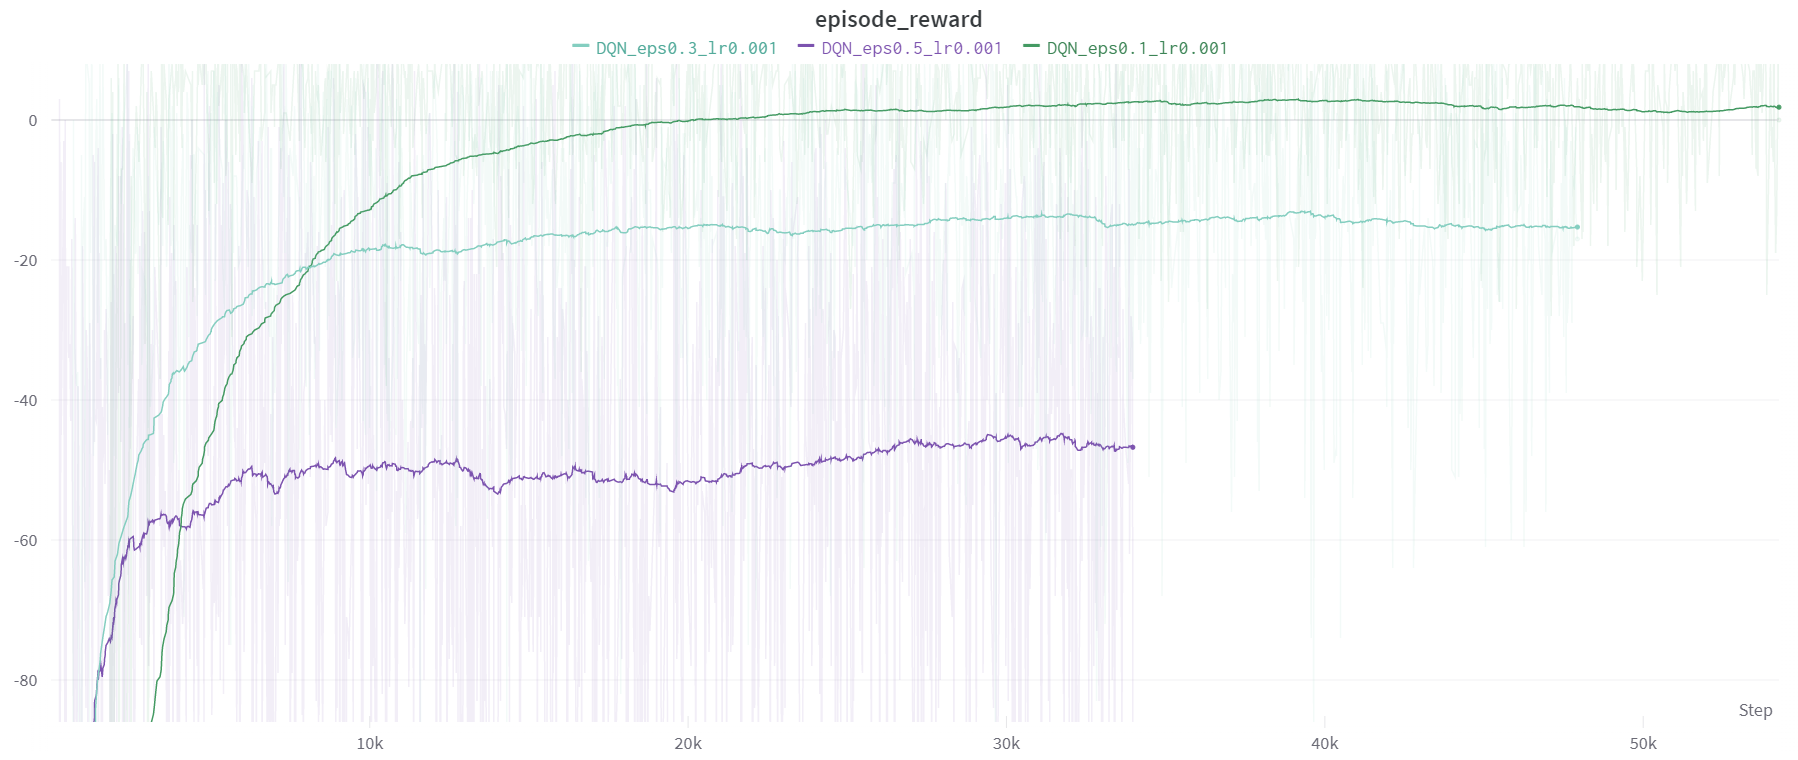
The graph above displays the average reward per step during an episode.

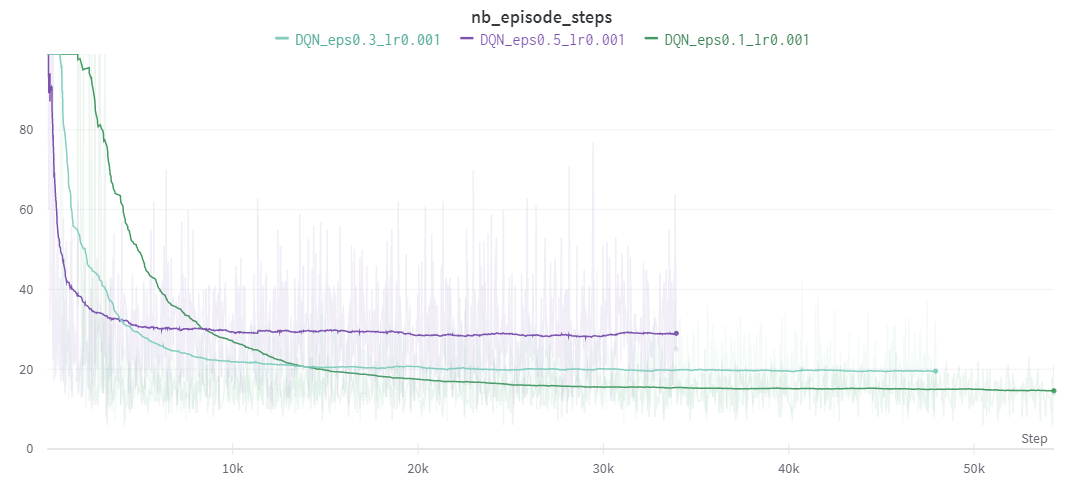
The graph above displays the number of steps the model takes to finish an episode.

As displayed on the graphs, find a correct value for the espilon parameter is mandatory.
<br>
As the model is quite reliable, random choice make the training less efficient.
<br><br>
While the 0.1 run ends up having a positive average reward, meaning the episode contains almost no error, both the 0.3 and 0.5 improve but not enough to be reliant.
<br>
<br>
So our optimal epsilon is 0.1.

### Impact of the learning rate parameter

The learning rate controls how quickly the model is adapted to the problem. Smaller learning rates require more training epochs given the smaller changes made to the weights each update, whereas larger learning rates result in rapid changes and require fewer training epochs.

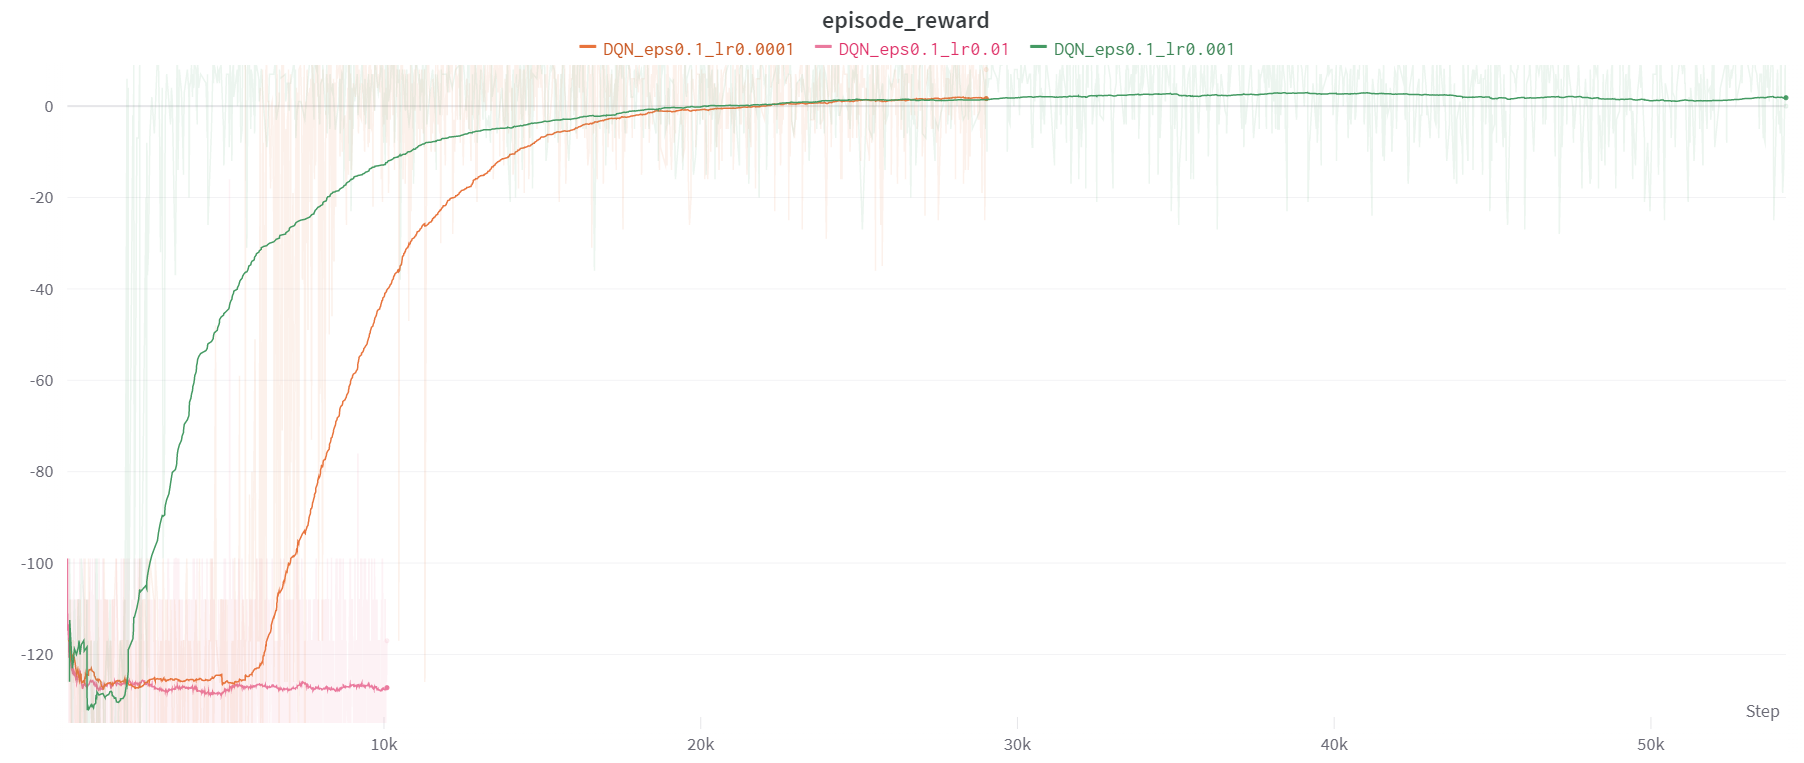
The graph above displays the average reward per step during an episode.

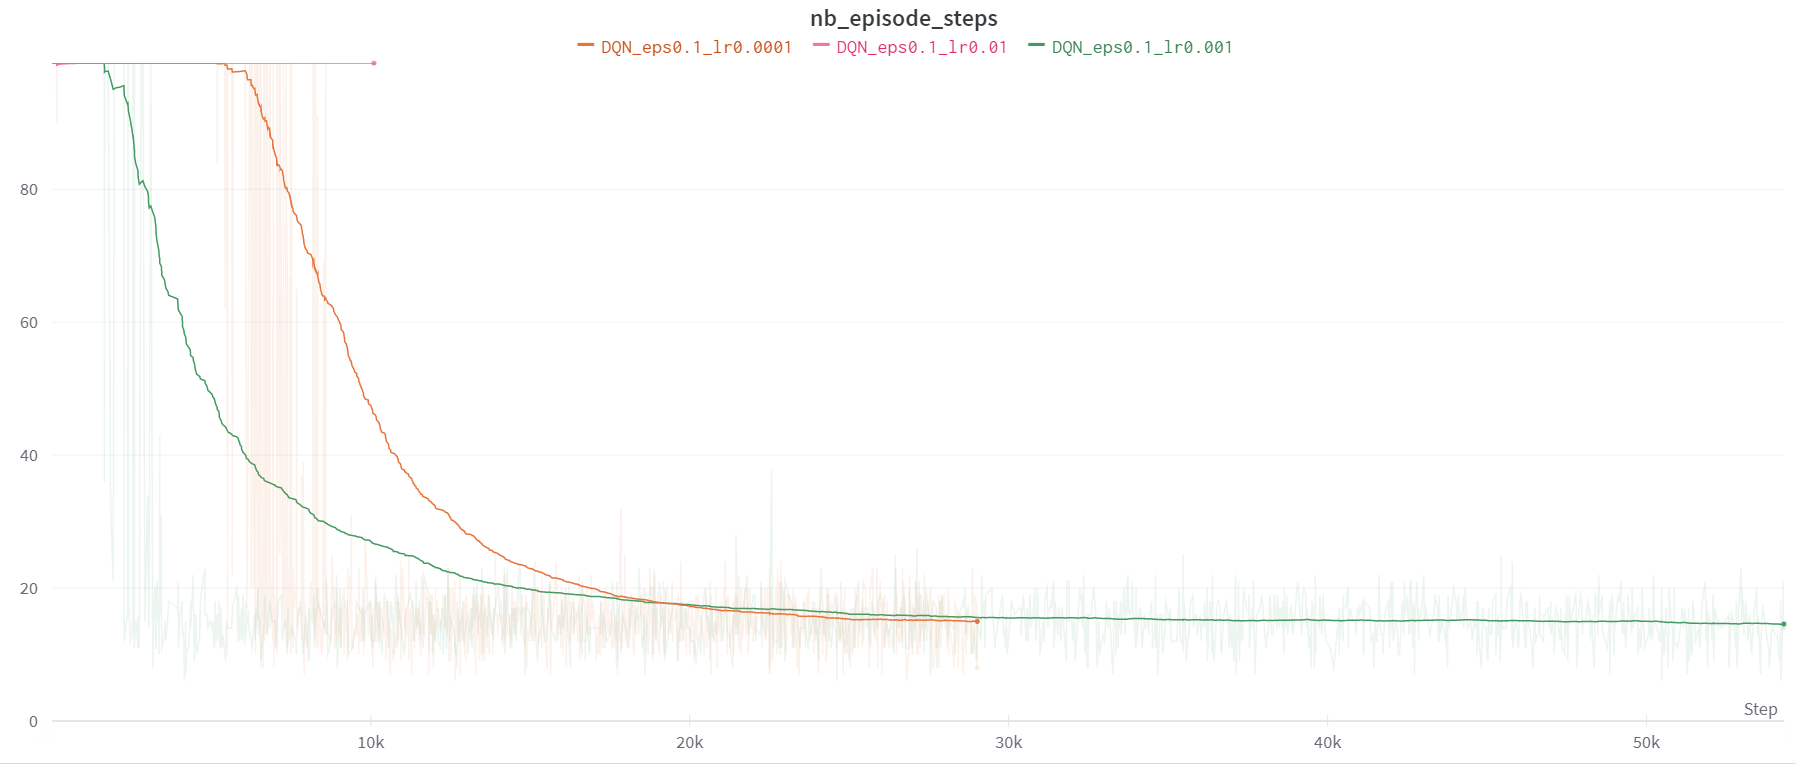

The graph above displays the number of steps the model takes to finish an episode.

These graphs teach us that a learning rate that is too large cause the model to reach too quickly a suboptimal solution, whereas a learning rate that is too small is take longer to improve even if, in the end, it can be quite well trained.

So, we choose the recommended learning rate for our model : 0.001.

### Impact of the number max of steps by episode

In order to find out if the maximum steps possible by episode is link with the performance of the model, we try a run with it value halves.

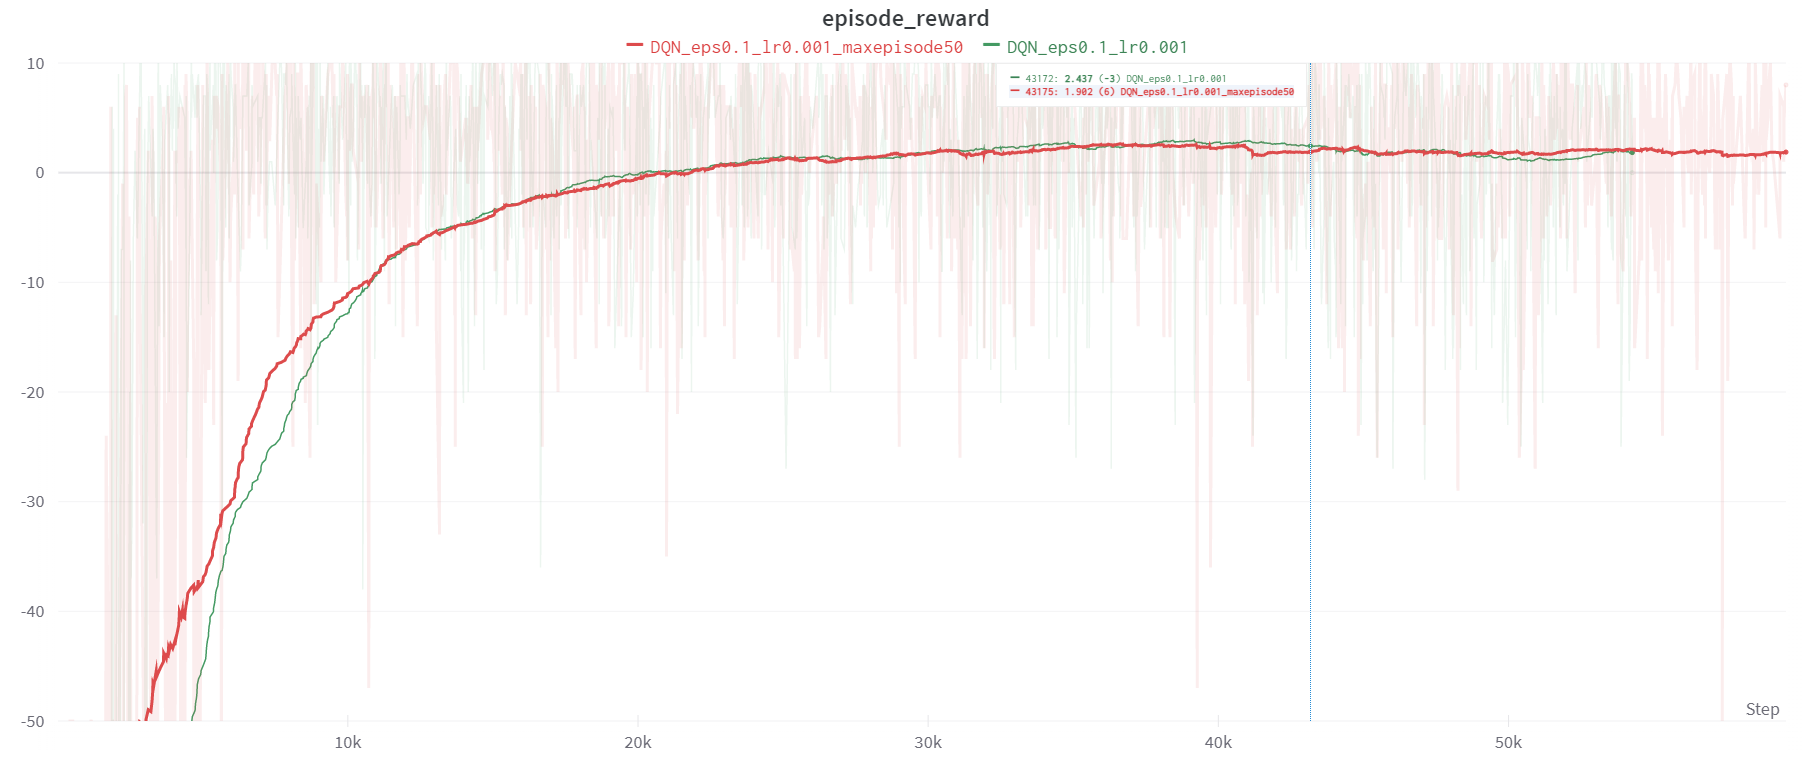
The graph above displays the average reward per step during an episode.

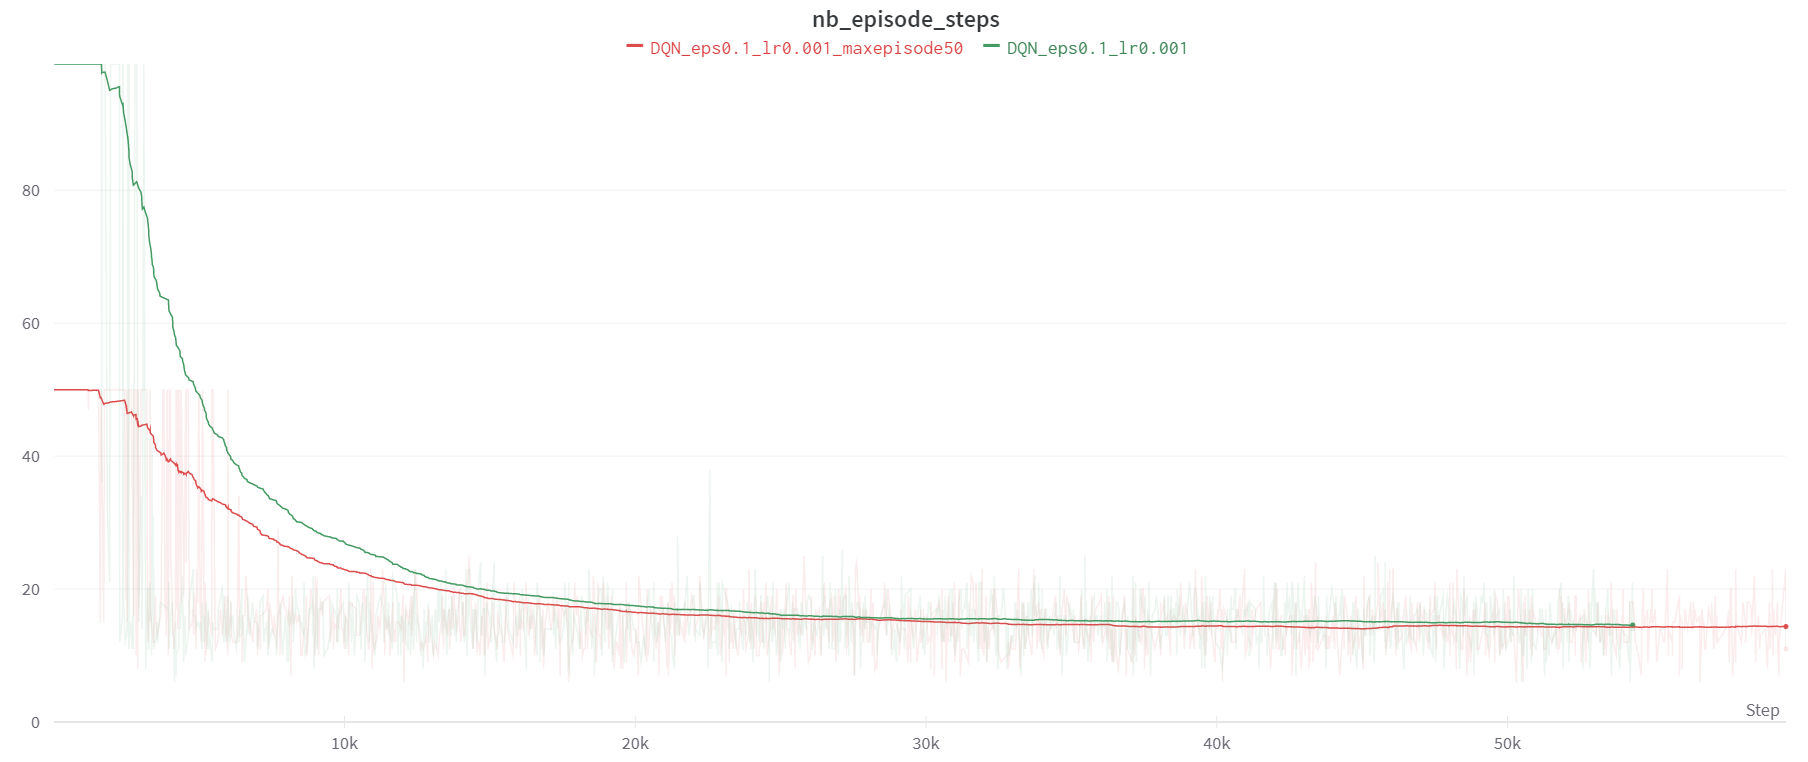
The graph above displays the number of steps the model takes to finish an episode.

The graphs show that there is no visible impact with a different maximum steps possible by episode. So we can keep it original value : 99.

### Best paramater for the DQN

After the differents tests, we decide to use the following configuration as our best DQN algorithm :


*   An espilon of 0.1
*   A learning rate of 0.001
*   A maximum step by episode of 99
*   A large training over 1 000 000 iterations



# Conclusion

Successfully ending a gym game is possible in many ways. Some are faster or lighter and other are just more reliable.
<br><br>
As we had seen during all the project, parameters are important for an algorithm to become efficient and reach it full power.
<br><br>
We decide to train, test and compare three algorithms : Q-learning, SARSA and DQN.
<br><br>
After many tests, comparison and analysis SARSA appears to be the best one.
<br><br>
Once well trained, it performance almost never decrease what ensure episodes of less than 20 steps.
Furthermore, SARSA reaches it peak performance in a really small amount of time.
<br><br>
Fast and efficient, SARSA is our gym's Taxi algorithm.

